In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
FILEPATH='data/block_2010_data/nhgis0005_csv'
relevant_cols = ['GISJOIN', 'STATEA', 'COUNTYA', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 
                               'H7X005', 'H7X006', 'H7X007', 'H7X008']
race_raw = pd.read_csv(f'{FILEPATH}/nhgis0005_ds172_2010_block.csv', 
                       usecols=relevant_cols, 
                       dtype={'GISJOIN': str, 'STATEA': str, 'COUNTYA': str})
column_mapper = dict(zip(relevant_cols, ['GISJOIN', 'state_fips', 'county_fips', 'total', 'white',
                                        'black', 'american_indian_al_native', 'asian', 
                                        'hawaiian_pac_islander', 'other', 'two_plus']))
race_raw.rename(columns=column_mapper, inplace=True)
print("Race data loaded.")
race_raw.set_index('GISJOIN', inplace=True)
race_raw

Race data loaded.


state_fips county_fips  total  white  black  \
GISJOIN                                                          
G06000104001001000         06         001      0      0      0   
G06000104001001001         06         001      0      0      0   
G06000104001001002         06         001      0      0      0   
G06000104001001003         06         001      0      0      0   
G06000104001001004         06         001      0      0      0   
...                       ...         ...    ...    ...    ...   
G42013300240022033         42         133     19     18      0   
G42013300240022034         42         133     48     48      0   
G42013300240022035         42         133     16     16      0   
G42013300240022036         42         133     44     35      2   
G42013300240022037         42         133     19     19      0   

                    american_indian_al_native  asian  hawaiian_pac_islander  \
GISJOIN                                                                       
G06000104001001000                          0      0                      0   
G06000104001001001                          0      0                      0   
G06000104001001002                          0      0                      0   
G06000104001001003                          0      0                      0   
G06000104001001004                          0      0                      0   
...                                       ...    ...                    ...   
G42013300240022033                          0      0                      0   
G42013300240022034                          0      0                      0   
G42013300240022035                          0      0                      0   
G42013300240022036                          0      0                      0   
G42013300240022037                          0      0                      0   

                    other  two_plus  
GISJOIN                              
G06000104001001000      0         0  
G06000104001001001      0         0  
G06000104001001002      0         0  
G06000104001001003      0         0  
G06000104001001004      0         0  
...                   ...       ...  
G42013300240022033      0         1  
G42013300240022034      0         0  
G42013300240022035      0         0  
G42013300240022036      0         7  
G42013300240022037      0         0  

[2699631 rows x 10 columns]

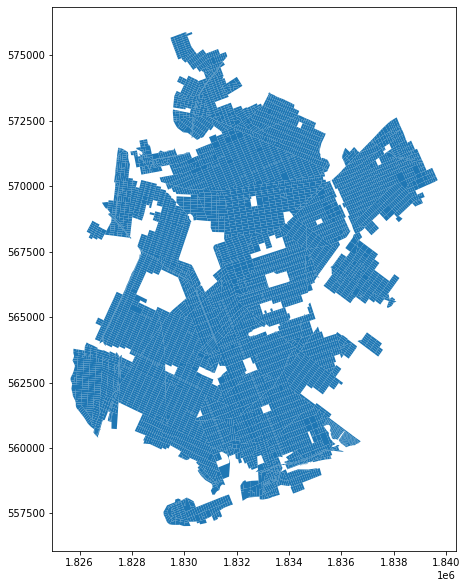

In [3]:
city_blocks = gpd.read_file(
    'data/block_2010_data/nhgis0005_shape/nhgis0005_shapefile_tl2010_360_block_2010/NY_block_2010.shp').set_index('GEOID10')
city_rl_cw = pd.read_csv('data/outputs/Brooklyn_blocks_2010_crosswalk.csv', dtype={'block_id_2010': str}).set_index('block_id_2010')
city_blocks = city_blocks.join(city_rl_cw, how='outer').dropna().set_index('GISJOIN')
city_blocks.plot(figsize=(10,10))

In [4]:
city = city_blocks.join(race_raw, how='outer').dropna()

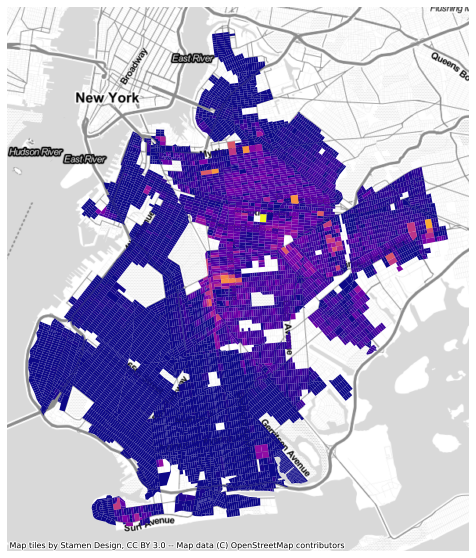

In [5]:
import contextily as ctx
def plot_map(df, column, figsize=(10,10), cmap='plasma'):
    ax = df.to_crs(epsg=3857).plot(figsize=figsize, cmap=cmap, column=column)
    ax.set_axis_off()
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

plot_map(city, 'black')

In [6]:
R = city.groupby('holc_id_uq').sum().filter(['total', 'white', 'black', \
    'american_indian_al_native', 'asian', 'hawaiian_pac_islander', \
    'hawaiian_pac_islander', 'other', 'two_plus'])

In [7]:
empty_districts = np.array(R.loc[(R.total == 0)].index)

In [8]:
race_matrix = city.filter(['total', 'white', 'black', 'american_indian_al_native', 'asian', 'hawaiian_pac_islander', 'other', 'two_plus', 'holc_id_uq', 'geometry'])
race_matrix.rename(columns={'holc_id_uq': 'partition'}, inplace=True)
# remove districts with population 0
race_matrix = race_matrix[~race_matrix['partition'].isin(empty_districts)]
race_matrix

total  white  black  american_indian_al_native  asian  \
GISJOIN                                                                     
G36004700001001000    181    157      4                          0     16   
G36004700001001001     16     15      0                          0      1   
G36004700001001002     31     26      0                          0      4   
G36004700001001003      0      0      0                          0      0   
G36004700001001005      0      0      0                          0      0   
...                   ...    ...    ...                        ...    ...   
G36004701522003005    171    133     16                          0      7   
G36004701522003006    187     69     77                          1     29   
G36004701522003007    127     23     72                          0     13   
G36004701522003008     79     52     24                          0      2   
G36004701522003009     61     34     19                          0      5   

                    hawaiian_pac_islander  other  two_plus partition  \
GISJOIN                                                                
G36004700001001000                      0      1         3       D59   
G36004700001001001                      0      0         0       D59   
G36004700001001002                      0      1         0       D59   
G36004700001001003                      0      0         0       D59   
G36004700001001005                      0      0         0       D59   
...                                   ...    ...       ...       ...   
G36004701522003005                      0      8         7       B15   
G36004701522003006                      0      3         8       B15   
G36004701522003007                      0      5        14       B15   
G36004701522003008                      0      0         1       B15   
G36004701522003009                      0      0         3       B15   

                                                             geometry  
GISJOIN                                                                
G36004700001001000  POLYGON ((1827608.736 571440.649, 1827671.770 ...  
G36004700001001001  POLYGON ((1827558.307 571456.260, 1827549.138 ...  
G36004700001001002  POLYGON ((1827500.885 571469.762, 1827524.494 ...  
G36004700001001003  POLYGON ((1827549.138 571396.563, 1827632.501 ...  
G36004700001001005  POLYGON ((1827515.460 571401.740, 1827512.617 ...  
...                                                               ...  
G36004701522003005  POLYGON ((1831536.247 565322.215, 1831475.217 ...  
G36004701522003006  POLYGON ((1831563.820 565348.865, 1831536.247 ...  
G36004701522003007  POLYGON ((1831597.310 565382.207, 1831563.820 ...  
G36004701522003008  POLYGON ((1831475.217 565262.807, 1831414.049 ...  
G36004701522003009  POLYGON ((1831385.182 565277.340, 1831272.595 ...  

[7940 rows x 10 columns]

In [9]:
def city_entropy(R, P):
    """
    Computes entropy of a city-region (see White, 1986).

    Parameters
    ----------
    R : numpy.ndarray
        i-by-j matrix, where i=districts and j=ethnicities.
    P : numpy.array
        i-length vector of the total population in a city-region.
    
    Returns
    -------
    int
        citywide segregation entropy score.
    """
    # define key terms in algorithm
    N = sum(P)
    i, j = R.shape
    R_prop = np.nan_to_num(np.apply_along_axis(lambda column: column / P, 0, R))
    r_hat = R.sum(axis=0) / N

    
    def entropy(x):
        """compute an entropy score with region ethnicity proportion vector x."""
        with np.errstate(divide='ignore'):
            vec = np.log(x)
        vec[np.isneginf(vec)] = 0 # fix special case where 0 * ln(0) = 0
        return (-1) * sum(x*vec)
    
    # compute district-level entropy scores
    h_i = list(map(entropy, R_prop))

    # compute city-wide entropy
    H_hat = entropy(r_hat)
    H_bar = sum((P/N) * h_i)
    
    return (H_hat - H_bar) / H_hat


In [10]:
def chain_to_entropy(chainobj, blocks):
    """
    Takes element in Markov Chain and computes entropy score using the partition map.
    Parameters
    ----------
    chainobj : gerrychain.partition.partition.Partition
        Partition object that dictates which elements belong to which partitions.
    blocks : geopandas.GeoDataFrame
        Dataframe containing the map's census blocks and associated race information.
    
    Returns
    -------
    int
        entropy score using the partition data from Markov Chain element.
    """
    # use partition parts and grouping to create R and P
    R = blocks.drop(columns=['geometry']).copy()
    R['partition'] = blocks.index.map(dict(chainobj.assignment))
    R = R.groupby('partition').sum()
    R, P = R.to_numpy()[:, 1:], R.to_numpy()[:, 0]

    return city_entropy(R, P)

In [11]:
def compute_total_pop(partition):
    global race_matrix
    R = race_matrix.drop(columns=['geometry']).copy()
    R['partition'] = race_matrix.index.map(dict(partition.assignment))
    return R.groupby('partition').sum()['total'].to_dict()

In [12]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain, proposals, updaters, constraints, accept)
from gerrychain.updaters import Tally
from gerrychain.constraints import Validator, LowerBound, UpperBound, WithinPercentRangeOfBounds
from gerrychain.proposals import recom, propose_chunk_flip, propose_random_flip
from gerrychain.accept import always_accept
from tqdm.notebook import tqdm
import networkx as nx

graph = Graph.from_geodataframe(race_matrix, adjacency='queen')

(1824950.7631103715, 1840378.154722861, 556074.7136465802, 576840.2763491705)

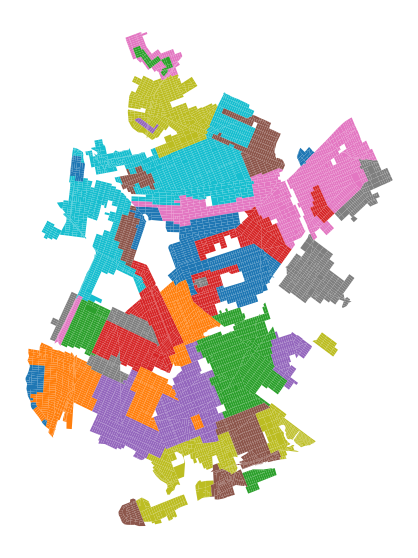

In [13]:
nx.set_node_attributes(graph, race_matrix['total'].to_dict(), name='population')
init_partition = Partition(graph, 
                    assignment=race_matrix.to_dict()['partition'],
                    updaters={'population' : Tally('population')})
init_partition.plot(figsize=(10,10))
plt.axis('off')

In [14]:
import seaborn as sns
from collections import Counter
plt.hist(list(init_partition['population'].values()), bins=100)
np.percentile(list(init_partition['population'].values()), [2.5, 97.5])
{key:value for (key, value) in init_partition['population'].items() if value == 0}
# this should output an empty dictionary. if not, do not run chain, remove these districts first

{}

(34990.77272727273, 53555.222703498905, 16426.322751046555, 27846.67496433926)

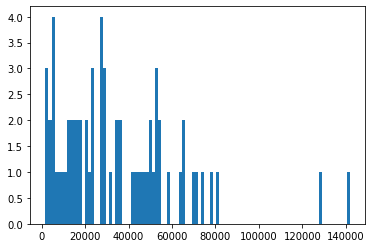

In [15]:
mean_pop = lambda part: np.mean(list(part['population'].values()))
min_pop = lambda part: min(list(part['population'].values()))
sd_pop = lambda part: np.std(list(part['population'].values()))
mean_one_sd_up = mean_pop(init_partition) + (2/3)*sd_pop(init_partition)
mean_one_sd_down = mean_pop(init_partition) - (2/3)*sd_pop(init_partition)
mean_pop(init_partition), mean_one_sd_up, mean_one_sd_down, sd_pop(init_partition)

In [16]:
is_valid = Validator([LowerBound(min_pop, min_pop(init_partition) % 50), 
    UpperBound(mean_pop, mean_one_sd_up), 
    LowerBound(mean_pop, mean_one_sd_down),
    WithinPercentRangeOfBounds(sd_pop, 25)])
BURN_IN = 1000
STEP_COUNT = 1000000
CITY_NAME = 'Brooklyn'
chunk_chain = MarkovChain(proposal=propose_chunk_flip, 
                    constraints=is_valid,
                    accept=always_accept, 
                    initial_state=init_partition, 
                    total_steps=STEP_COUNT + BURN_IN)
random_chain = MarkovChain(proposal=propose_random_flip, 
                    constraints=is_valid,
                    accept=always_accept, 
                    initial_state=init_partition, 
                    total_steps=STEP_COUNT + BURN_IN)
print('Prereqs created, Chunk flip chain running...')
# burn-in of 1000
iter(chunk_chain)
print("Burn-in:")
_ = [next(chunk_chain) for i in tqdm(range(BURN_IN))]
chunk_entropies = [chain_to_entropy(next(chunk_chain), race_matrix) for i in tqdm(range(STEP_COUNT))]
del chunk_chain
np.save(f"results/arrays/{CITY_NAME.lower()}_cf_{STEP_COUNT}.npy", chunk_entropies)

print('Random flip chain running...')
# burn-in of 1000
iter(random_chain)
print("Burn-in:")
_ = [next(random_chain) for i in tqdm(range(BURN_IN))]
random_entropies = [chain_to_entropy(next(random_chain), race_matrix) for i in tqdm(range(STEP_COUNT))]
del random_chain
np.save(f"results/arrays/{CITY_NAME.lower()}_rf_{STEP_COUNT}.npy", random_entropies)


Prereqs created, Chunk flip chain running...
Burn-in:


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.xlabel("City-wide Entropy Score")
plt.ylabel("Density")
sns.kdeplot(chunk_entropies)
plt.scatter(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), 0, c='r')

plt.subplot(1, 2, 2)
plt.xlabel("Step in Markov Chain")
plt.ylabel("City-wide Entropy Score")
plt.plot(chunk_entropies)
plt.plot(np.repeat(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), STEP_COUNT), c='r')

plt.suptitle(f"Chunk Flip Entropies for {CITY_NAME}, run for {STEP_COUNT} steps", y=1.02)
plt.tight_layout()
plt.savefig(f"results/plots/{CITY_NAME.lower()}_cf_{STEP_COUNT}.png")

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.xlabel("City-wide Entropy Score")
plt.ylabel("Density")
sns.kdeplot(random_entropies)
plt.scatter(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), 0, c='r')

plt.subplot(1, 2, 2)
plt.xlabel("Step in Markov Chain")
plt.ylabel("City-wide Entropy Score")
plt.plot(random_entropies)
plt.plot(np.repeat(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), STEP_COUNT), c='r')

plt.suptitle(f"Random Flip Entropies for {CITY_NAME}, run for {STEP_COUNT} steps", y=1.02)
plt.tight_layout()
plt.savefig(f"results/plots/{CITY_NAME.lower()}_rf_{STEP_COUNT}.png")